In [6]:
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn import tree
import plotly.express as px
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)
from sklearn import preprocessing
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import shap
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score

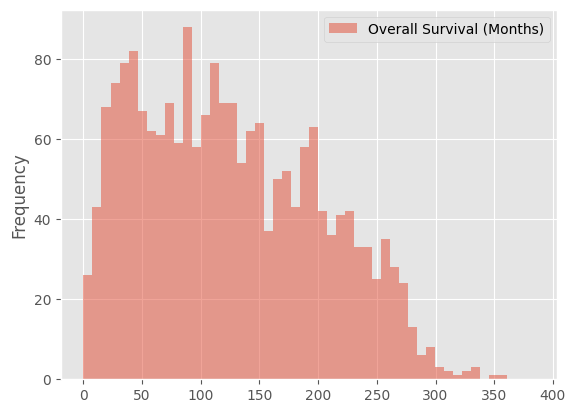

In [9]:
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')
ax = df.plot.hist(column = 'Overall Survival (Months)',bins=50, alpha=0.5)

In [10]:
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


In [11]:
#https://www.cancer.net/cancer-types/breast-cancer/statistics
#99% of people survive over 60 months
#80% of people survive over 180 months
#use these as our short- and long-survival periods
for i, month in enumerate(df['Overall Survival (Months)']):
    if month<=60: 
        surv = str(month).replace(str(month),'Short-Term') #short term = 0
        df.at[i,'Overall Survival (Months)'] = surv
    elif month>=180:
        surv = str(month).replace(str(month),'Long-Term') #long term = 1 
        df.at[i,'Overall Survival (Months)'] = surv
    else:
        df.drop(i,axis=0,inplace=True)

In [40]:
#some of the data is NA: find out how much and where
print(df.isna().sum())
#lots of missing values. usually you can throw them out but we have to fill them in 
#by imputing the data: for numerical data, use median (so that mean doesn't skew by outliers)
#					   for categorical data, use most frequent type

#     #for numerical type:
print(df.select_dtypes(include=(['int64','float64'])).isna().sum())
#get columns of numerical values that are na
df_num_col = df.select_dtypes(include=(['int64','float64'])).columns
for c in df_num_col:
    df[c].fillna(df[c].median(),inplace=True) #replace missing values with median
# #now check that there are no more missing values:
# print(df.select_dtypes(include=(['int64','float64'])).isna().sum())

#for categorical type:
# print(df.select_dtypes(include=(['object'])).isna().sum())
df_cat_col = df.select_dtypes(include=(['object'])).columns
for c in df_cat_col:
    df[c].fillna(df[c].mode().values[0],inplace=True) #replace missing values with most common type

#now check that there are no non-null values
print(df.isna().sum())
print(df.select_dtypes(include=(['int64','float64'])).isna().sum())

Study ID                            0
Patient ID                          0
Sample ID                           0
Age at Diagnosis                    0
Type of Breast Surgery             19
Cancer Type                         0
Cancer Type Detailed                0
Cellularity                        24
Chemotherapy                        0
Pam50 + Claudin-low subtype         0
Cohort                              0
ER status measured by IHC          20
ER Status                           0
Neoplasm Histologic Grade          41
HER2 status measured by SNP6        0
HER2 Status                         0
Tumor Other Histologic Subtype     19
Hormone Therapy                     0
Inferred Menopausal State           0
Integrative Cluster                 0
Primary Tumor Laterality           65
Lymph nodes examined positive      42
Mutation Count                     58
Nottingham prognostic index         0
Oncotree Code                       0
Overall Survival (Months)           0
Overall Surv

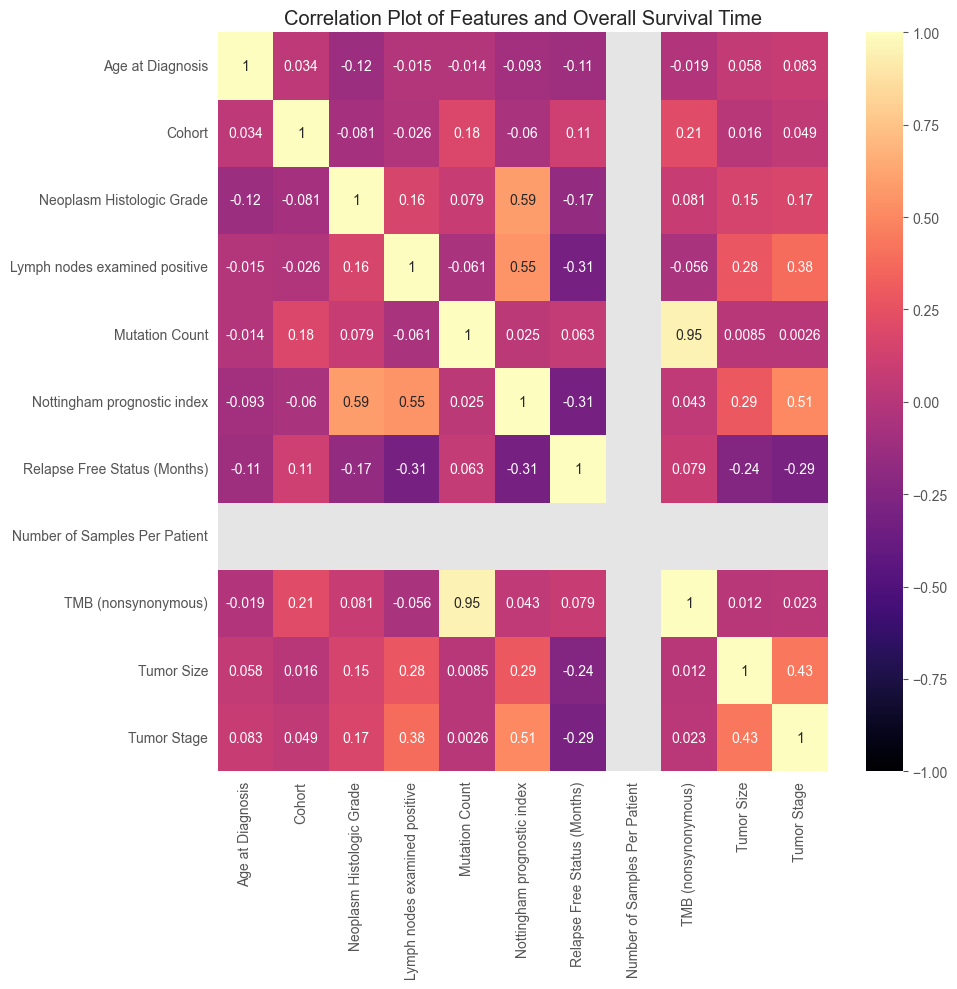

In [41]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),vmin=-1,cmap='magma',annot=True)
plt.title('Correlation Plot of Features and Overall Survival Time')   
plt.tight_layout()
plt.show()
#see heart disease has high negative corr w maxhr, cholesterol, and pos corr w oldpeak,fastingbs,restingbp

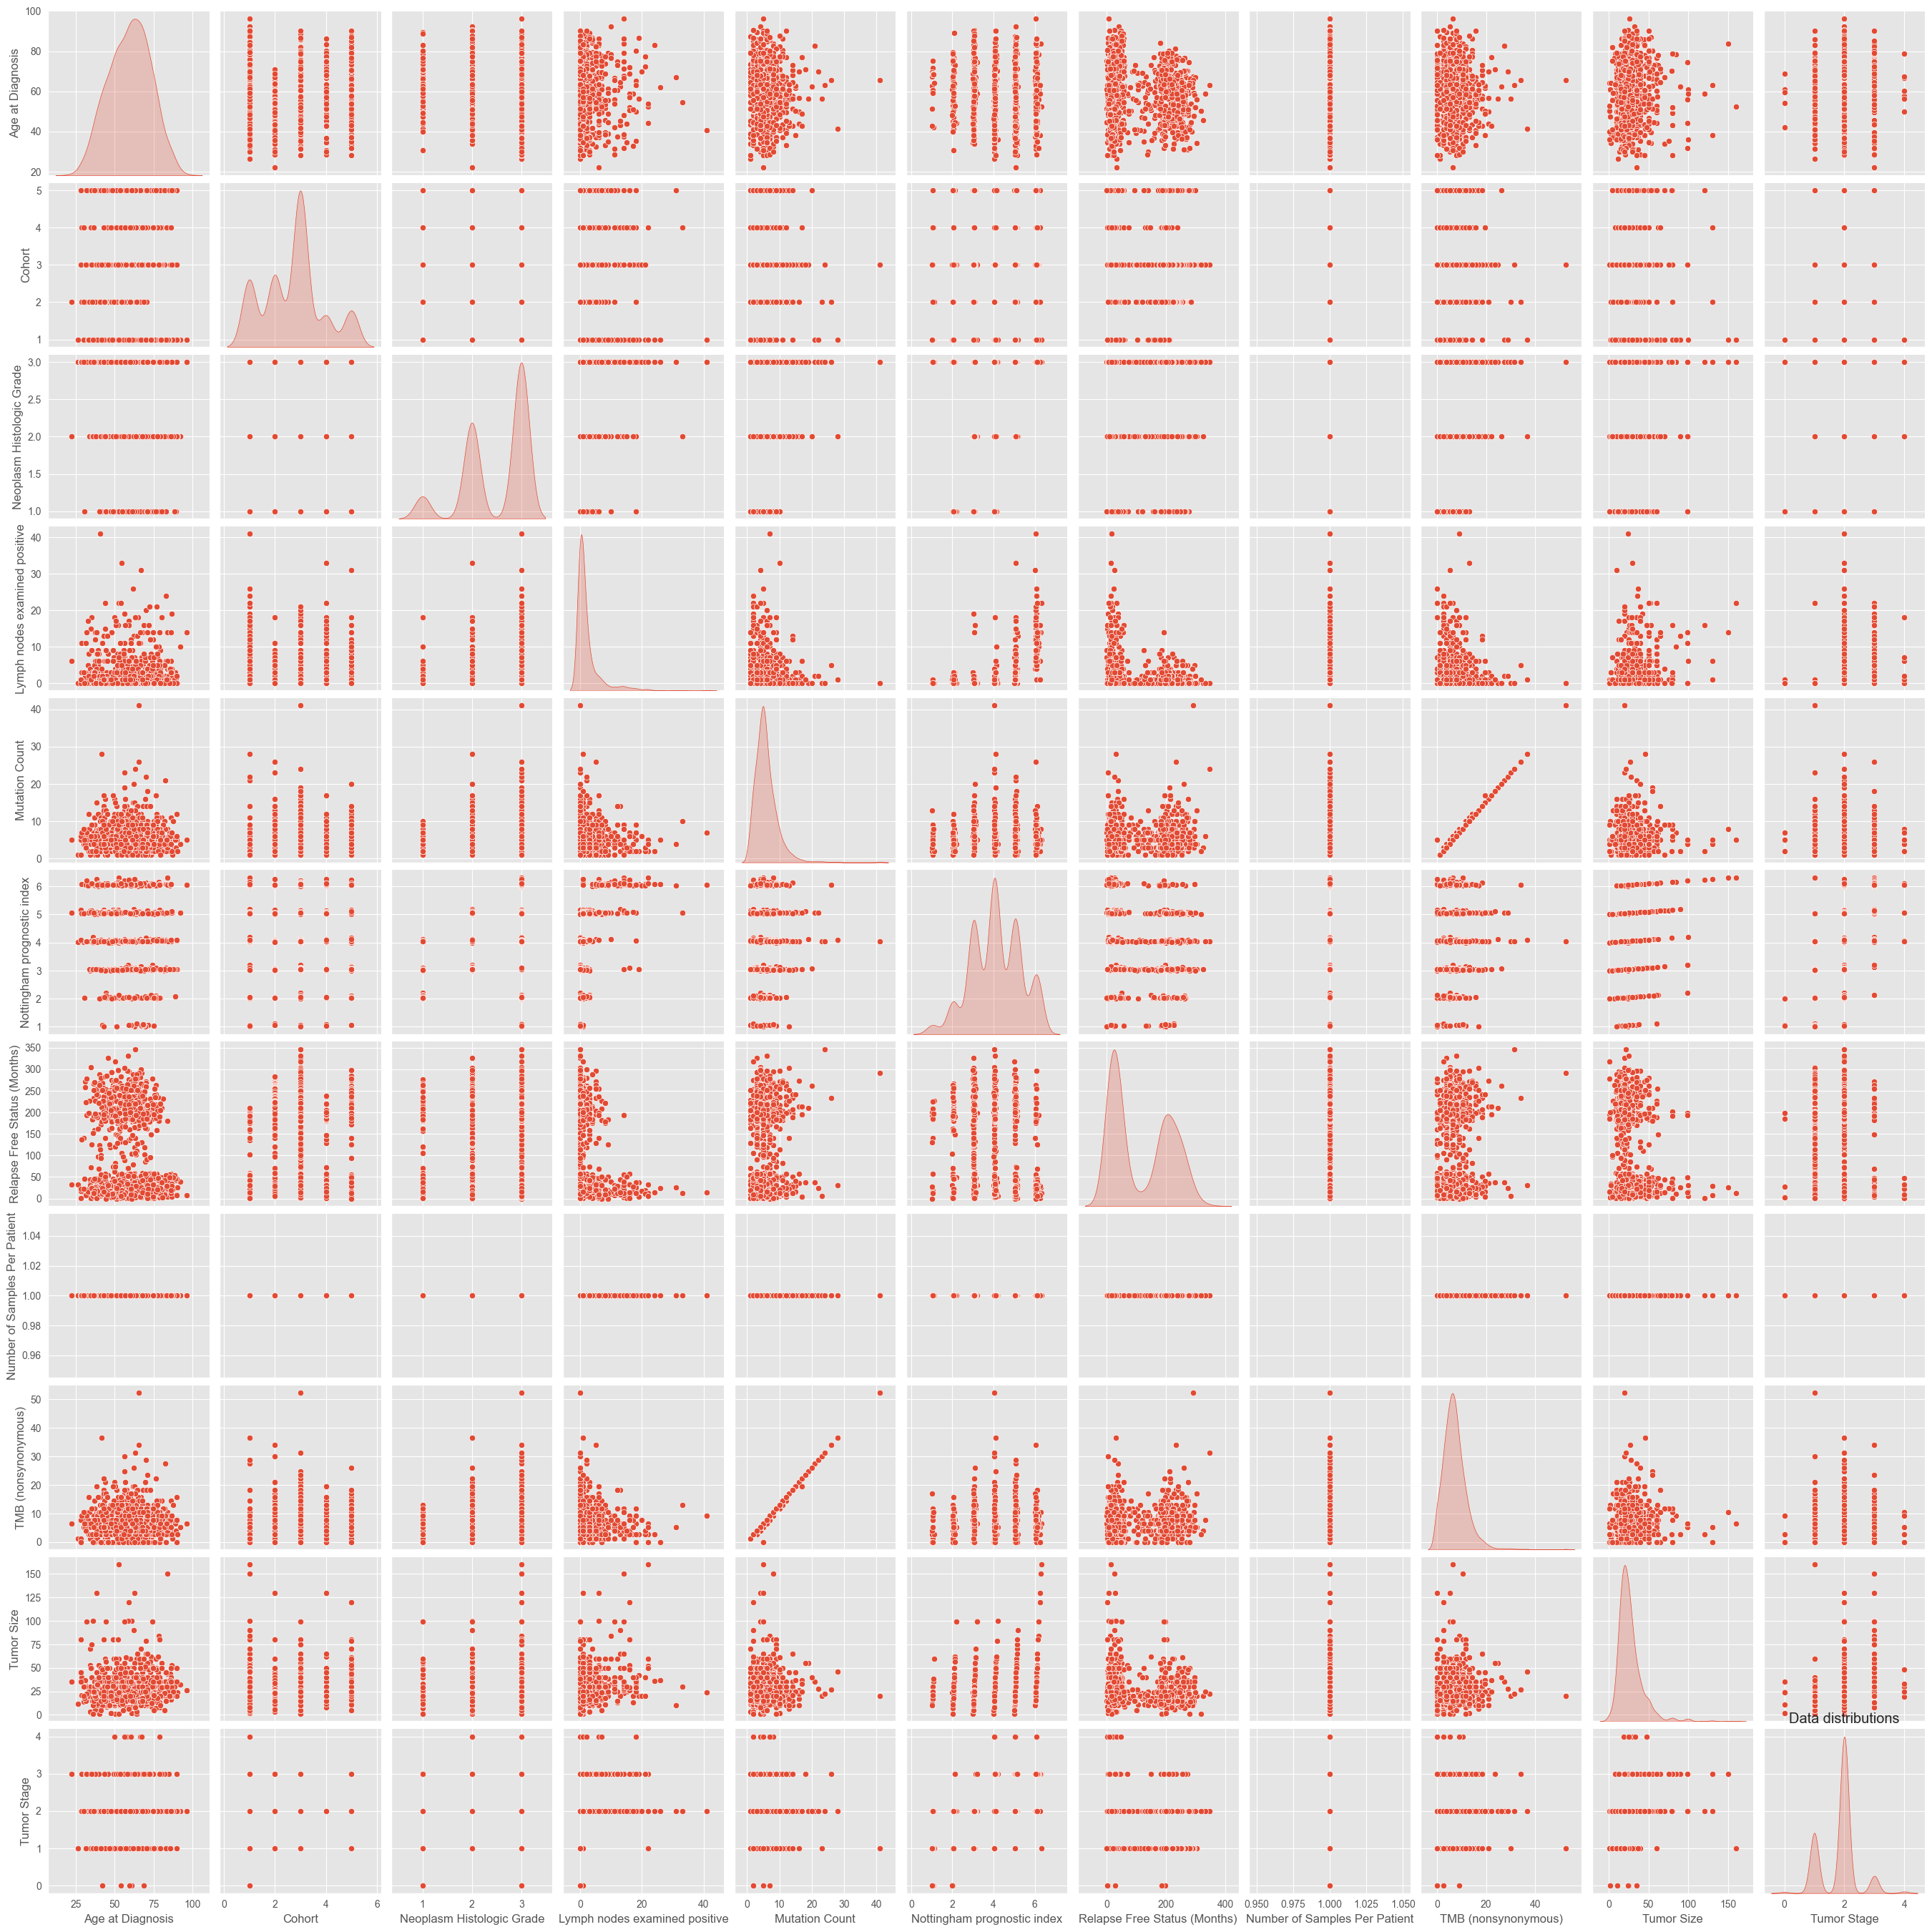

In [42]:
#use pairplot() to show relationship of multiple vairables. diagonals are univariate
# plt.figure(figsize=(15,10))
sns.pairplot(df,diag_kind='kde')
# plt.tight_layout()
plt.title('Data distributions')
plt.plot()
plt.show()

In [43]:
#one hot encoding
# df.info()
for col in df:
    print(col)
    print(df[col].unique())
# print(df.columns)

Study ID
['brca_metabric']
Patient ID
['MB-0008' 'MB-0010' 'MB-0020' ... 'MB-7295' 'MB-7296' 'MB-7299']
Sample ID
['MB-0008' 'MB-0010' 'MB-0020' ... 'MB-7295' 'MB-7296' 'MB-7299']
Age at Diagnosis
[76.97 78.77 70.   86.41 84.22 83.02 50.42 80.5  68.68 43.15 83.89 36.96
 48.59 60.07 72.1  73.98 63.53 73.11 57.99 85.39 79.28 53.16 77.13 67.7
 62.72 60.85 50.43 57.56 37.87 53.75 76.4  64.57 83.99 85.94 56.39 76.84
 82.65 57.79 81.02 51.54 86.24 79.38 42.95 37.24 77.72 50.31 59.15 58.21
 63.35 41.98 71.57 44.73 43.63 52.19 51.25 66.75 53.45 53.1  38.99 55.44
 83.93 46.44 66.54 45.39 29.98 68.66 61.94 34.3  69.52 51.81 60.3  51.42
 48.07 62.92 49.92 51.19 80.34 68.83 82.53 51.21 89.43 67.38 55.52 73.48
 56.32 50.82 92.14 86.28 66.73 62.81 90.43 32.61 52.24 49.05 69.53 61.32
 86.26 73.01 58.16 57.87 44.21 40.5  52.79 63.31 34.68 66.58 56.28 68.74
 80.38 58.56 56.41 55.28 48.58 72.85 54.22 66.72 44.02 83.17 85.21 69.79
 61.67 49.87 59.45 63.2  61.11 90.02 85.09 58.98 87.18 33.97 59.34 39.53
 

In [44]:
df = pd.get_dummies(df, columns=["Patient's Vital Status",'Integrative Cluster','Oncotree Code','Primary Tumor Laterality','Inferred Menopausal State','Tumor Other Histologic Subtype','HER2 status measured by SNP6','Type of Breast Surgery','3-Gene classifier subtype','Cancer Type','Cancer Type Detailed','Pam50 + Claudin-low subtype','Cellularity'])
df.drop(['Study ID','Patient ID','Sample ID','Sample Type','Sex','Number of Samples Per Patient'],axis=1,inplace=True)
df['Radio Therapy'] = df['Radio Therapy'].replace({'YES':1,'NO':0}) 
df['Chemotherapy'] = df['Chemotherapy'].replace({'YES':1,'NO':0})
df['Hormone Therapy'] = df['Hormone Therapy'].replace({'YES':1,'NO':0})
df['PR Status'] = df['PR Status'].replace({'Positive':1,'Negative':0})
df['ER Status'] = df['ER Status'].replace({'Positive':1,'Negative':0})
df['ER status measured by IHC'] = df['ER status measured by IHC'].replace({'Positve':1,'Negative':0})
df['Relapse Free Status'] = df['Relapse Free Status'].replace({'1:Recurred':1,'0:Not Recurred':0})
df['HER2 Status'] = df['HER2 Status'].replace({'Positive':1,'Negative':0})
df['Overall Survival (Months)'] = df['Overall Survival (Months)'].replace({'Short-Term':0,'Long-Term':1})
df['Overall Survival Status'] = df['Overall Survival Status'].replace({'1:DECEASED':0,'0:LIVING':1})
for col in df:
    print(col)
    print(df[col].unique())

Age at Diagnosis
[76.97 78.77 70.   86.41 84.22 83.02 50.42 80.5  68.68 43.15 83.89 36.96
 48.59 60.07 72.1  73.98 63.53 73.11 57.99 85.39 79.28 53.16 77.13 67.7
 62.72 60.85 50.43 57.56 37.87 53.75 76.4  64.57 83.99 85.94 56.39 76.84
 82.65 57.79 81.02 51.54 86.24 79.38 42.95 37.24 77.72 50.31 59.15 58.21
 63.35 41.98 71.57 44.73 43.63 52.19 51.25 66.75 53.45 53.1  38.99 55.44
 83.93 46.44 66.54 45.39 29.98 68.66 61.94 34.3  69.52 51.81 60.3  51.42
 48.07 62.92 49.92 51.19 80.34 68.83 82.53 51.21 89.43 67.38 55.52 73.48
 56.32 50.82 92.14 86.28 66.73 62.81 90.43 32.61 52.24 49.05 69.53 61.32
 86.26 73.01 58.16 57.87 44.21 40.5  52.79 63.31 34.68 66.58 56.28 68.74
 80.38 58.56 56.41 55.28 48.58 72.85 54.22 66.72 44.02 83.17 85.21 69.79
 61.67 49.87 59.45 63.2  61.11 90.02 85.09 58.98 87.18 33.97 59.34 39.53
 60.78 77.22 60.74 58.71 42.89 52.2  54.08 53.64 67.46 46.66 61.89 66.11
 39.3  83.92 51.45 76.32 48.39 61.28 74.96 68.99 68.47 96.29 84.76 62.34
 77.96 32.99 83.19 60.2  38.75 75.9

In [45]:
X = df
y = df.pop('Overall Survival (Months)')

In [46]:
acc = []
skf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
model = RandomForestClassifier(n_estimators=200,criterion='entropy')

def training(train,test,fold_no):
    X_train = train
    y_train = y.iloc[train_index]
    X_test = test
    y_test = y.iloc[test_index]
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    acc.append(score)
    print(f'For fold {fold_no} the accuracy is {score}')

fold_no = 1
for train_index,test_index in skf.split(X,y):
    train = X.iloc[train_index,:]
    test = X.iloc[test_index,:]
    training(train,test,fold_no)
    fold_no += 1
print(f'RandomForest model mean accuracy = {np.mean(acc)}')

For fold 1 the accuracy is 0.9509803921568627
For fold 2 the accuracy is 0.9803921568627451
For fold 3 the accuracy is 1.0
For fold 4 the accuracy is 0.9901960784313726
For fold 5 the accuracy is 1.0
For fold 6 the accuracy is 0.9901960784313726
For fold 7 the accuracy is 1.0
For fold 8 the accuracy is 0.9901960784313726
For fold 9 the accuracy is 0.9900990099009901
For fold 10 the accuracy is 0.9900990099009901
RandomForest model mean accuracy = 0.9882158804115708


In [47]:
RF_model_predict = model.predict(test)
RF_model_predict_proba = model.predict_proba(test)
print(classification_report(y.iloc[test_index],RF_model_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       1.00      0.98      0.99        52

    accuracy                           0.99       101
   macro avg       0.99      0.99      0.99       101
weighted avg       0.99      0.99      0.99       101



In [48]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,threshold = roc_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
roc_auc = auc(fpr,tpr)
print(f'AUC: {roc_auc_score(y.iloc[test_index],RF_model_predict_proba[:,1])}')

AUC: 0.9996075353218211


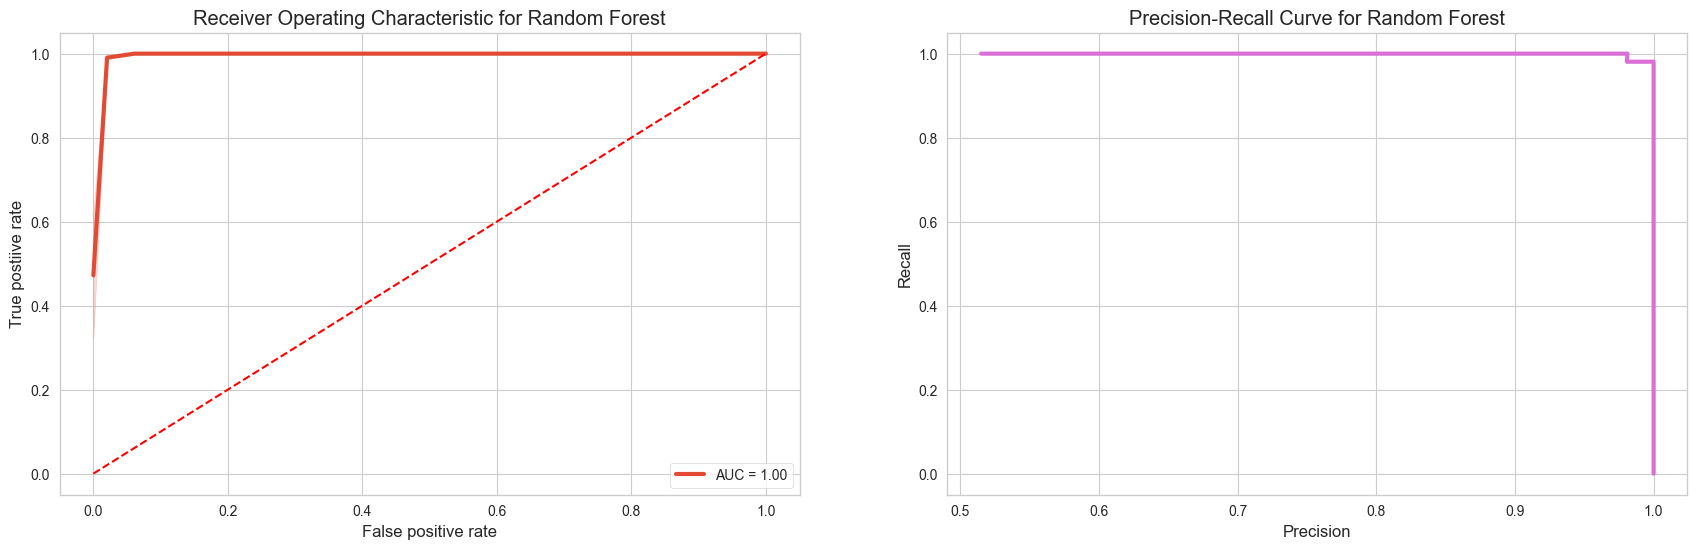

In [49]:
sns.set_style('whitegrid')
plt.figure(figsize=(21,6))

plt.subplot(1,2,1)
plt.title('Receiver Operating Characteristic for Random Forest')
sns.lineplot(x=fpr,y=tpr,label='AUC = %0.2f' % roc_auc,palette='purple',linewidth=3)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.xlabel('False positive rate')
plt.ylabel('True postiive rate')

precision, recall, thresholds = precision_recall_curve(y.iloc[test_index],RF_model_predict_proba[:,1])
plt.subplot(1,2,2)
plt.plot(precision,recall,linewidth=3,color='orchid')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve for Random Forest')

plt.show()

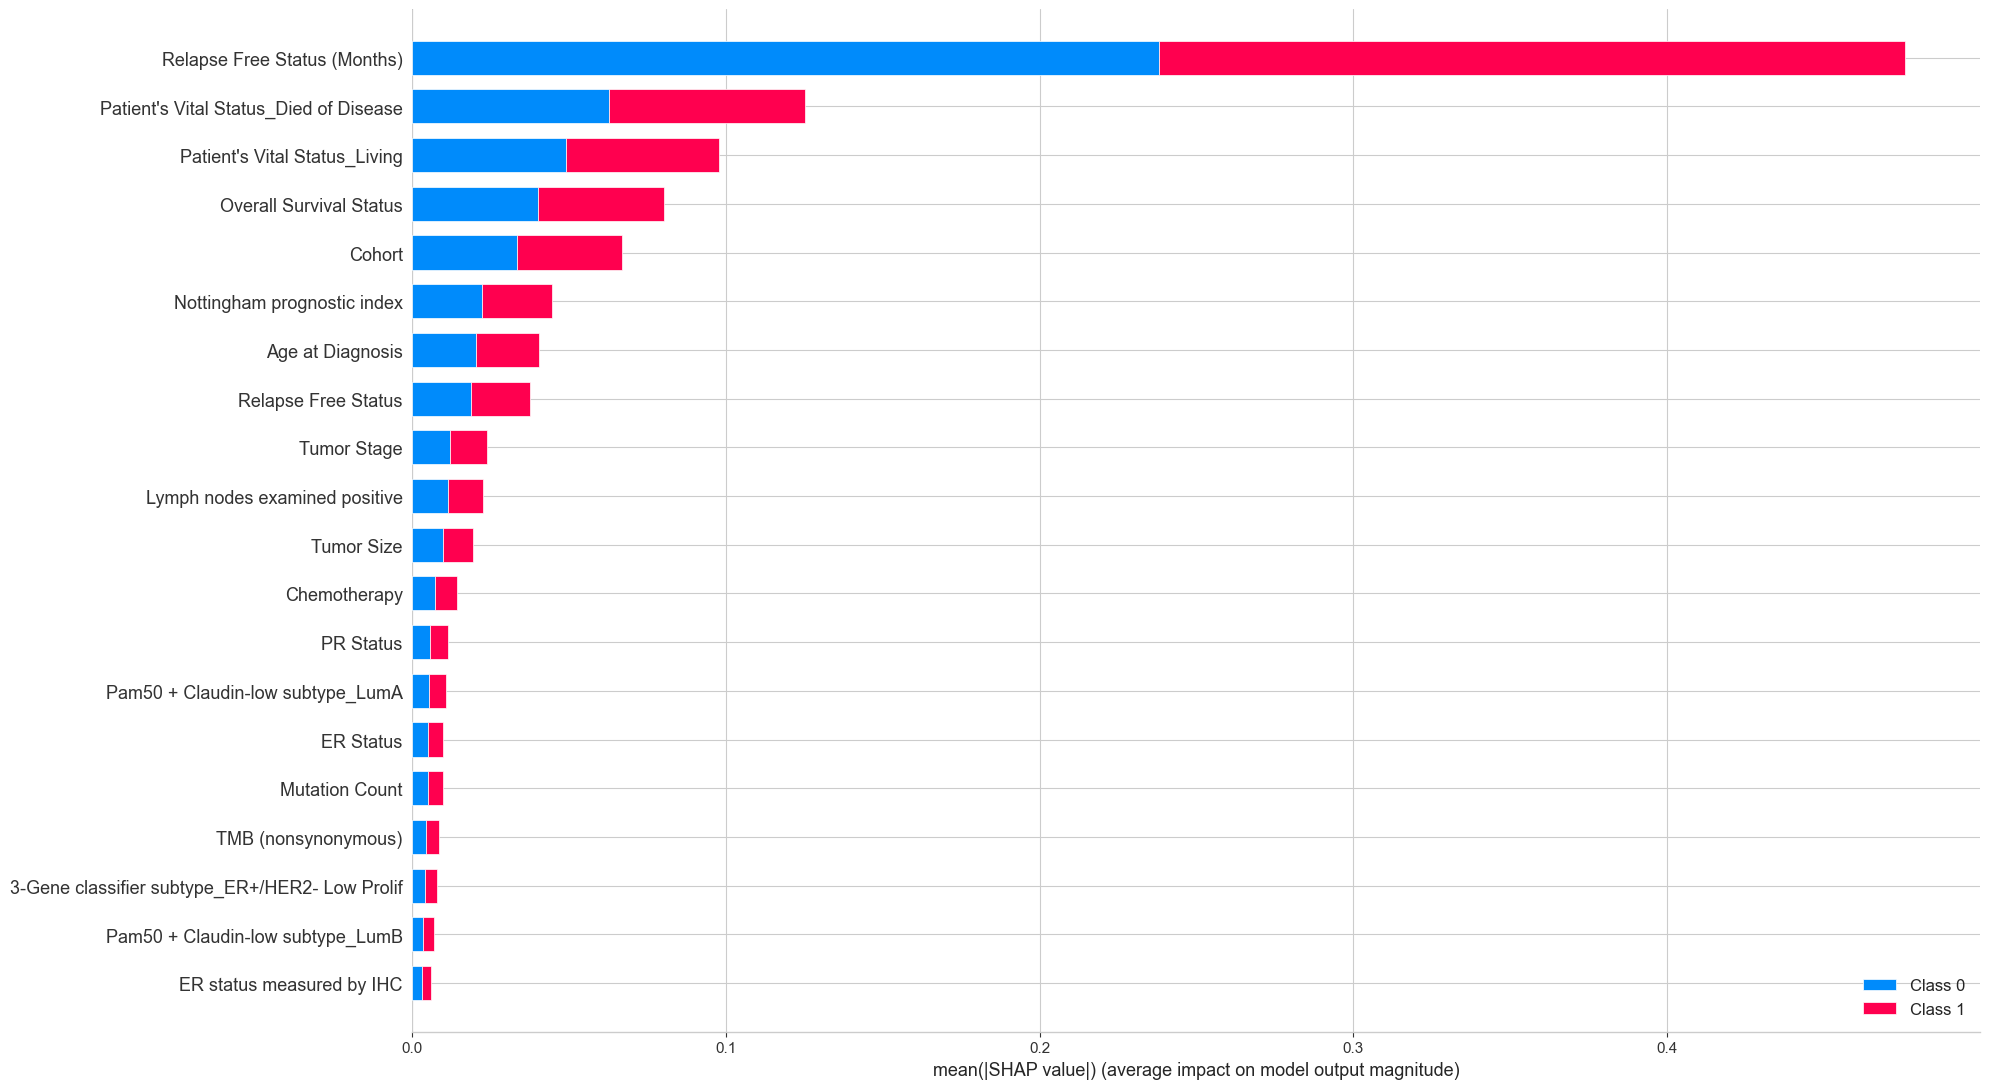

In [50]:
plt.clf()

# use SHAP package to evaluate which features are most important for predicting class.
# shap score --> higher = more likely to predict class. 

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values,train,plot_size=(20,11),alpha=0.2,plot_type='bar',show=False)
plt.show()